In [26]:
!pip install yfinance statsmodels pmdarima matplotlib
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
import itertools
warnings.filterwarnings("ignore")

[*********************100%***********************]  1 of 1 completed


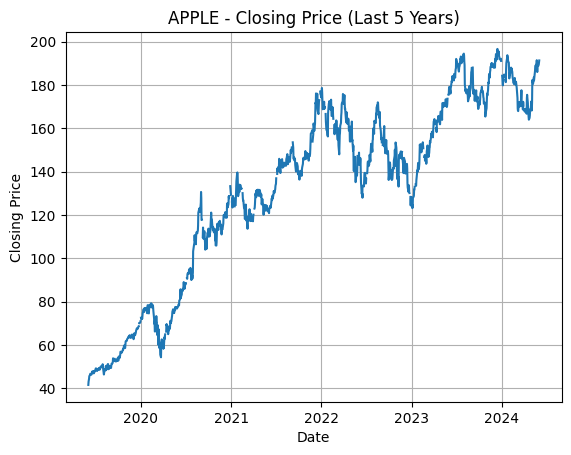

In [74]:
data = yf.download("AAPL", start="2019-06-01", end="2024-06-01")['Close']
data.dropna(inplace=True)
data = data.asfreq('B')  # Setting business day frequency
plt.plot(data)
plt.title("APPLE - Closing Price (Last 5 Years)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.grid()
plt.show()

In [75]:
result = adfuller(data.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])
if result[1] < 0.05:
    print("=> Data is stationary.")
else:
    print("=> Data is non-stationary.")


ADF Statistic: -1.6432374923726554
p-value: 0.46056961424469883
Critical Values: {'1%': np.float64(-3.4355588184378574), '5%': np.float64(-2.8638402312881497), '10%': np.float64(-2.5679946684494275)}
=> Data is non-stationary.


In [76]:
d = 0
diff_data = data.copy()
while True:
    result = adfuller(diff_data.dropna())
    if result[1] < 0.05:
        break
    diff_data = diff_data.diff().dropna()
    d += 1

print(f"\nMade data stationary by differencing {d} time(s)")


Made data stationary by differencing 1 time(s)


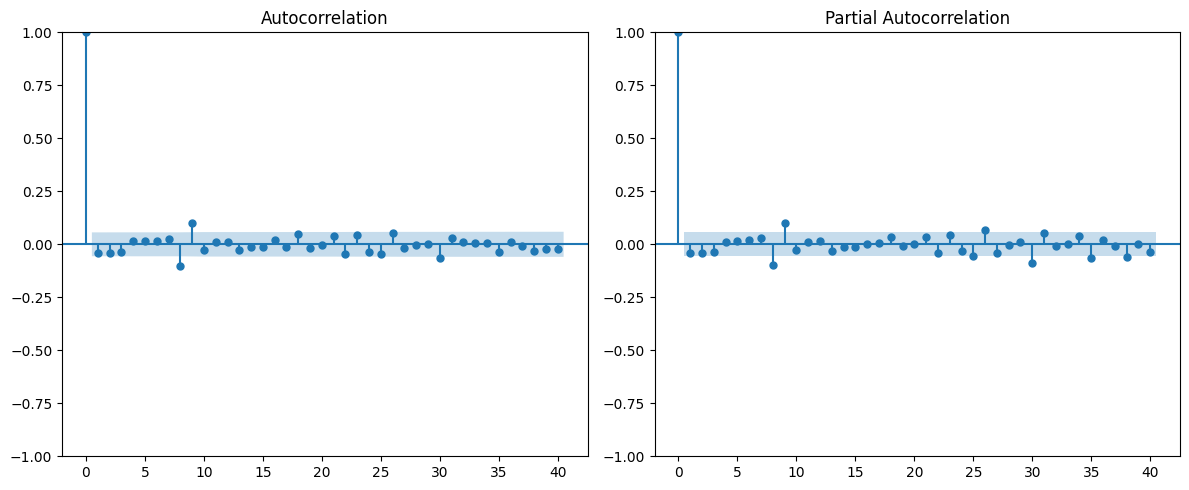

In [77]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(diff_data, ax=plt.gca(), lags=40)
plt.subplot(1, 2, 2)
plot_pacf(diff_data, ax=plt.gca(), lags=40)
plt.tight_layout()
plt.show()

In [78]:
from statsmodels.tsa.arima.model import ARIMA

# Defining p, d, q range
#since differencing is required
p = q = range(0, 4)
d = range(1,2)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_order = None
split = int(len(data) * 0.80) #testing on data of roughly 3 months
train, test = data[:split], data[split:]
print("Trying combinations:")
for order in pdq:
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        print(f"ARIMA{order} AIC: {model_fit.aic}")
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
    except:
        continue

print("\nBest ARIMA order:", best_order)


Trying combinations:
ARIMA(0, 1, 0) AIC: 4696.817623335175
ARIMA(0, 1, 1) AIC: 4694.622267553289
ARIMA(0, 1, 2) AIC: 4695.091193668648
ARIMA(0, 1, 3) AIC: 4696.806356423361
ARIMA(1, 1, 0) AIC: 4694.961592631807
ARIMA(1, 1, 1) AIC: 4695.251209993551
ARIMA(1, 1, 2) AIC: 4696.974037989703
ARIMA(1, 1, 3) AIC: 4698.725306569639
ARIMA(2, 1, 0) AIC: 4695.268280882741
ARIMA(2, 1, 1) AIC: 4698.93183771273
ARIMA(2, 1, 2) AIC: 4697.932930012789
ARIMA(2, 1, 3) AIC: 4698.611860184021
ARIMA(3, 1, 0) AIC: 4696.555033723376
ARIMA(3, 1, 1) AIC: 4698.525898734847
ARIMA(3, 1, 2) AIC: 4698.743704475302
ARIMA(3, 1, 3) AIC: 4701.906829276624

Best ARIMA order: (0, 1, 1)


In [79]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order = best_order)
model_fit = model.fit()
print(model_fit.summary())

arima_forecast = model_fit.forecast(steps=len(test))
arima_fitted_values = model_fit.fittedvalues
arima_forecast.index = test.index

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 1044
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2345.311
Date:                Sun, 29 Jun 2025   AIC                           4694.622
Time:                        01:18:47   BIC                           4704.522
Sample:                    06-03-2019   HQIC                          4698.377
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0675      0.025     -2.707      0.007      -0.116      -0.019
sigma2         6.0357      0.190     31.815      0.000       5.664       6.407
Ljung-Box (L1) (Q):                   0.00   Jarque-

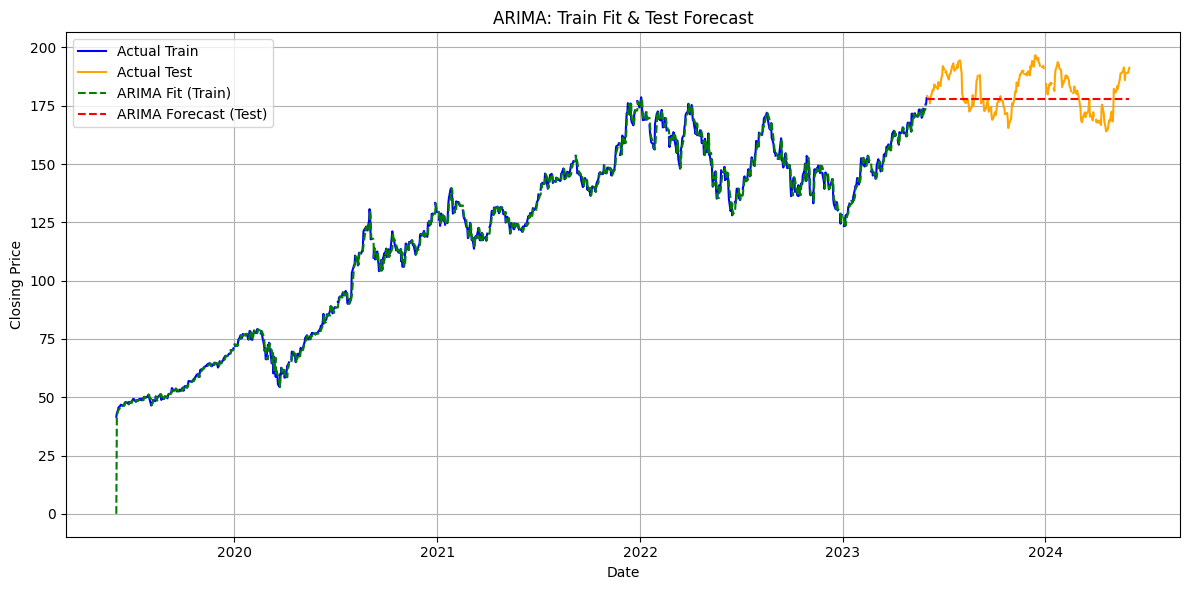

In [80]:
plt.figure(figsize=(12, 6))

# Plot actual train and test
plt.plot(train, label="Actual Train", color='blue')
plt.plot(test, label="Actual Test", color='orange')

# Plot fitted values on train
plt.plot(arima_fitted_values, label="ARIMA Fit (Train)", color='green', linestyle='--')

# Plot forecast on test
plt.plot(arima_forecast, label="ARIMA Forecast (Test)", color='red', linestyle='--')

# Title and legends
plt.title("ARIMA: Train Fit & Test Forecast")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np


# Drop NaNs and align
arima_fitted_values_clean = arima_fitted_values.dropna()
train_aligned = train.loc[arima_fitted_values_clean.index].dropna()

# Ensure same index
common_index = arima_fitted_values_clean.index.intersection(train_aligned.index)

# Final aligned series
fitted_final = arima_fitted_values_clean.loc[common_index].dropna()
train_final = train_aligned.loc[common_index].dropna()

# Equal length
min_len = min(len(fitted_final), len(train_final))
fitted_final = fitted_final[-min_len:]
train_final = train_final[-min_len:]

# Test RMSE for ARIMA

# Drop NaNs and align
arima_forecast_clean = arima_forecast.dropna()
test_clean = test.loc[arima_forecast_clean.index].dropna()

min_len_test = min(len(arima_forecast_clean), len(test_clean))
arima_forecast_final = arima_forecast_clean[-min_len_test:]
test_final = test_clean[-min_len_test:]

# Test RMSE
test_rmse_arima = np.sqrt(mean_squared_error(test_final, arima_forecast_final))
arima_mape = mean_absolute_percentage_error(test_final, arima_forecast_final)*100

print(f"ARIMA Test RMSE: {test_rmse_arima:.3f}")
print(f"ARIMA Test MAPE: {arima_mape:.3f}%")

ARIMA Test RMSE: 8.866
ARIMA Test MAPE: 4.172%


In [82]:
# Defining p, d, q range
s = 5;
P =  Q = range(0, 3)
D = range(0,2);
  # For weekly seasonality in stock data (Mon–Fri)

PDQ = list(itertools.product(P, D, Q))
seasonal_PDQs = [(p, d, q, s) for (p, d, q) in PDQ]

best_seasonal_aic = np.inf
best_seasonal_order = None

print("Trying combinations:")
for seasonal_order in seasonal_PDQs:
    try:
        sarima_model = SARIMAX(train,
                        order=best_order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        sarima_model_fit = sarima_model.fit()
        print(f"SARIMA{seasonal_order} AIC: {sarima_model_fit.aic}")
        if sarima_model_fit.aic < best_seasonal_aic:
            best_seasonal_aic = sarima_model_fit.aic
            best_seasonal_order = seasonal_order
    except:
        continue

print("\nBest SARIMA order:", best_seasonal_order)


Trying combinations:
SARIMA(0, 0, 0, 5) AIC: 4686.8554592722285
SARIMA(0, 0, 1, 5) AIC: 4668.702728083825
SARIMA(0, 0, 2, 5) AIC: 4648.004359286433
SARIMA(0, 1, 0, 5) AIC: 5335.685244279854
SARIMA(0, 1, 1, 5) AIC: 4669.472551839193
SARIMA(0, 1, 2, 5) AIC: 4651.472975143366
SARIMA(1, 0, 0, 5) AIC: 4676.215034759423
SARIMA(1, 0, 1, 5) AIC: 4669.885366507121
SARIMA(1, 0, 2, 5) AIC: 4649.8052877869595
SARIMA(1, 1, 0, 5) AIC: 5094.796650197859
SARIMA(1, 1, 1, 5) AIC: 4672.874238839482
SARIMA(1, 1, 2, 5) AIC: 4650.558988542207
SARIMA(2, 0, 0, 5) AIC: 4655.21067100947
SARIMA(2, 0, 1, 5) AIC: 4657.027659388699
SARIMA(2, 0, 2, 5) AIC: 4651.437107702999
SARIMA(2, 1, 0, 5) AIC: 4951.923845398225
SARIMA(2, 1, 1, 5) AIC: 4659.864891970263
SARIMA(2, 1, 2, 5) AIC: 4652.448112986984

Best SARIMA order: (0, 0, 2, 5)


In [83]:
sarima_model = SARIMAX(train,
                       order=best_order,
                       seasonal_order=(0,0,0,5),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit()
print(sarima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 1044
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2341.428
Date:                Sun, 29 Jun 2025   AIC                           4686.855
Time:                        01:19:43   BIC                           4696.751
Sample:                    06-03-2019   HQIC                          4690.609
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0678      0.025     -2.717      0.007      -0.117      -0.019
sigma2         6.0448      0.190     31.763      0.000       5.672       6.418
Ljung-Box (L1) (Q):                   0.00   Jarque-

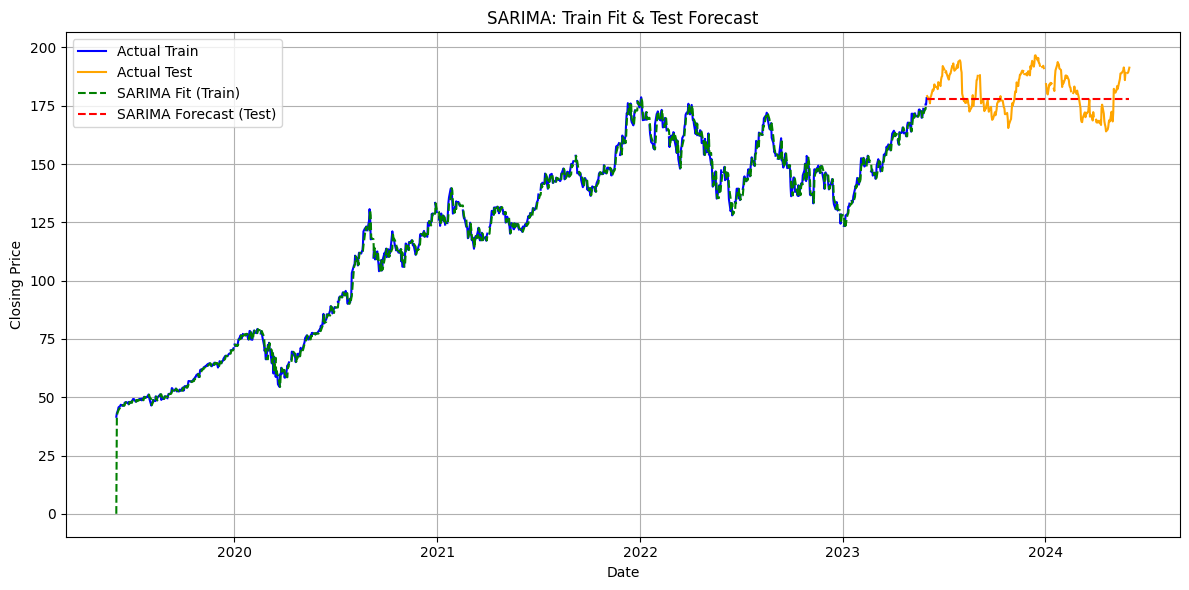

In [86]:
# Fitted values on train
sarima_fitted_values = sarima_result.fittedvalues

# Forecast on test
forecast_sarima = sarima_result.forecast(steps=len(test))
forecast_sarima.index = test.index  # Align with test set

# Plot everything
plt.figure(figsize=(12, 6))
plt.plot(train, label="Actual Train", color='blue')
plt.plot(test, label="Actual Test", color='orange')
plt.plot(sarima_fitted_values, label="SARIMA Fit (Train)", color='green', linestyle='--')
plt.plot(forecast_sarima, label="SARIMA Forecast (Test)", color='red', linestyle='--')

plt.title("SARIMA: Train Fit & Test Forecast")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [87]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Drop NaNs from both fitted and actual train data
sarima_fitted_values_clean = sarima_fitted_values.dropna()
train_aligned = train.loc[sarima_fitted_values_clean.index].dropna()

# Ensure matching index
common_index = sarima_fitted_values_clean.index.intersection(train_aligned.index)

# Filter both to matching dates only and drop NaNs again (final cleanup)
fitted_final = sarima_fitted_values_clean.loc[common_index].dropna()
train_final = train_aligned.loc[common_index].dropna()

# Final safeguard: ensure same length
min_len = min(len(train_final), len(fitted_final))
train_final = train_final[-min_len:]
fitted_final = fitted_final[-min_len:]

# Test RMSE for SARIMA
forecast_sarima_clean = forecast_sarima.dropna()
test_clean = test.loc[forecast_sarima_clean.index].dropna()

# Align lengths
min_len_test = min(len(forecast_sarima_clean), len(test_clean))
forecast_sarima_final = forecast_sarima_clean[-min_len_test:]
test_final = test_clean[-min_len_test:]


rmse = np.sqrt(mean_squared_error(test_final, forecast_sarima_final))
mape = mean_absolute_percentage_error(test_final, forecast_sarima_final)*100

print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.3f}%")



RMSE: 8.866
MAPE: 4.172%
